### Install & Import Dependencies

In [16]:
!pip install xgboost scikit-learn openai matplotlib groq

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score, precision_recall_curve
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from groq import Groq
from kaggle_secrets import UserSecretsClient
import seaborn as sns
import shap

### Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/brca-multiomics-tcga/data.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (705, 1937)


,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p27.pT198,pp_p38.MAPK,pp_p38.pT180.Y182,pp_p53,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.043330,-0.002598,0.449228,-0.375230,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,-0.220764,0.220809,1.035115,-0.074136,0.279067,0.292925,-0.155242,-0.089365,0.267530,0
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.010615,-0.133214,0.344969,-0.351936,0.219910,0.308110,-0.190794,-0.222150,-0.198518,0
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,0.064070,-0.384008,0.678042,0.096329,-0.266554,-0.079871,-0.463237,0.522998,-0.046902,0
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.065488,0.209858,0.920408,0.042210,-0.441542,-0.152317,0.511386,-0.096482,0.037473,0


In [3]:
df.describe()

,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p27.pT198,pp_p38.MAPK,pp_p38.pT180.Y182,pp_p53,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,...,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,4.547197,6.487979,9.516678,7.351940,8.179439,7.806726,5.677454,8.721931,7.450675,7.747601,...,0.008589,0.004734,0.059332,-0.094355,0.109583,-0.028409,0.048929,-0.002065,0.019180,0.133333
std,4.971708,4.874769,4.758348,4.248440,4.291915,4.325965,4.331351,4.130467,4.244499,4.245585,...,0.254308,0.302194,0.544589,0.579644,0.811079,0.555587,0.377429,0.345646,0.291446,0.340176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.918200,-1.432959,-1.637550,-3.017238,-2.646594,-2.152630,-0.751501,-1.334300,-1.182336,0.000000
25%,0.000000,2.297602,5.937361,3.842758,5.144707,4.612299,1.436695,5.784499,4.171967,4.688113,...,-0.141888,-0.168875,-0.276563,-0.302937,-0.426244,-0.317636,-0.207172,-0.232004,-0.147140,0.000000
50%,2.379261,6.002963,10.011822,7.701500,9.043774,7.530813,5.866248,9.305378,7.999344,8.277510,...,-0.022655,0.006428,0.084549,-0.067906,-0.005234,-0.067527,-0.039654,-0.010013,0.006341,0.000000
75%,8.025802,9.503384,13.087360,10.493654,11.536532,11.157128,10.132437,11.948430,10.559780,10.785635,...,0.136848,0.183828,0.413358,0.180853,0.573340,0.206411,0.211573,0.212412,0.172476,0.000000
max,17.432087,20.960773,20.978437,19.979807,17.338611,19.132935,14.702210,18.662764,17.355330,17.892925,...,1.051862,1.483391,2.349841,2.069048,3.043258,2.475027,1.664292,1.545965,1.062551,1.000000


## Preprocessing

### Target column split

In [4]:
target_col = "vital.status"
X = df.drop(columns=[target_col])
y = df[target_col]

print("Unique values:", y.unique())
print("Value counts:\n", y.value_counts())

Unique values: [0 1]
Value counts:
 vital.status
0    611
1     94
Name: count, dtype: int64


In [5]:
feature_names = df.columns[:-1]
feature_names

Index(['rs_CLEC3A', 'rs_CPB1', 'rs_SCGB2A2', 'rs_SCGB1D2', 'rs_TFF1',
       'rs_MUCL1', 'rs_GSTM1', 'rs_PIP', 'rs_ADIPOQ', 'rs_ADH1B',
       ...
       'pp_p27.pT157', 'pp_p27.pT198', 'pp_p38.MAPK', 'pp_p38.pT180.Y182',
       'pp_p53', 'pp_p62.LCK.ligand', 'pp_p70S6K', 'pp_p70S6K.pT389',
       'pp_p90RSK', 'pp_p90RSK.pT359.S363'],
      dtype='object', length=1936)

### Train/Test Split

#####  1. Split first (to avoid leakage)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (564, 1936) Test size: (141, 1936)


##### 2. Normalize baseline dataset

In [7]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Keeping these for Baseline Model
X_train_baseline, X_test_baseline = X_train_norm, X_test_norm
y_train_baseline, y_test_baseline = y_train, y_test

##### 3. Create Balanced Training Set

In [8]:
# Converting to DataFrame for resampling
train_df = pd.DataFrame(X_train, columns=X.columns)
train_df["vital.status"] = y_train.values

# Separating majority and minority
df_majority = train_df[train_df["vital.status"] == 0]
df_minority = train_df[train_df["vital.status"] == 1]

# Upsampling minority
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Combining them back
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Splitting into features and labels
X_train_bal = df_balanced.drop(columns=["vital.status"])
y_train_bal = df_balanced["vital.status"]

# Normalizing balanced dataset 
scaler_bal = StandardScaler()
X_train_bal_norm = scaler_bal.fit_transform(X_train_bal)
X_test_bal_norm = scaler_bal.transform(X_test) 

print("Baseline:", X_train_baseline.shape, "Balanced:", X_train_bal_norm.shape)

X_train_balanced, y_train_balanced = X_train_bal_norm, y_train_bal
X_test_balanced, y_test_balanced = X_test_bal_norm, y_test 

Baseline: (564, 1936) Balanced: (978, 1936)


## 1. Train XGBoost Model

In [9]:
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train
model.fit(X_train_baseline, y_train_baseline)

# Predict
y_pred_baseline = model.predict(X_test_baseline)
y_proba_baseline = model.predict_proba(X_test_baseline)[:,1]

# Evaluate
print("Accuracy:", accuracy_score(y_test_baseline, y_pred_baseline))
print("\nClassification Report:\n", classification_report(y_test_baseline, y_pred_baseline))

Accuracy: 0.8936170212765957

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       122
           1       1.00      0.21      0.35        19

    accuracy                           0.89       141
   macro avg       0.95      0.61      0.64       141
weighted avg       0.91      0.89      0.86       141



## 2. Train XGBoost Model with Class Imbalance

In [10]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict
y_pred_imbalance = xgb_model.predict(X_test_balanced)
y_proba_imbalance = xgb_model.predict_proba(X_test_balanced)[:,1]

# Evaluate
print("Accuracy:", accuracy_score(y_test_balanced, y_pred_imbalance))
print("Classification Report:\n", classification_report(y_test_balanced, y_pred_imbalance))

Accuracy: 0.900709219858156
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.95       122
           1       0.86      0.32      0.46        19

    accuracy                           0.90       141
   macro avg       0.88      0.65      0.70       141
weighted avg       0.90      0.90      0.88       141



### Collect Results for Report

In [11]:
def evaluate_model(y_true, y_pred, model_name="model"):
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    results_summary = {
        "model": model_name,
        "accuracy": acc,
        "precision_survived": report['1']['precision'],
        "recall_survived": report['1']['recall'],
        "f1_survived": report['1']['f1-score'],
        "precision_died": report['0']['precision'],
        "recall_died": report['0']['recall'],
        "f1_died": report['0']['f1-score']
    }
    return results_summary


# Evaluate both models
baseline_summary = evaluate_model(y_test_baseline, y_pred_baseline, "XGB Baseline")
imbalance_summary = evaluate_model(y_test_balanced, y_pred_imbalance, "XGB w/ Imbalance")

# Put in one dictionary for easy access
all_results = {
    "baseline": baseline_summary,
    "imbalance": imbalance_summary
}

print("Summaries prepared for LLM:\n", all_results)

Summaries prepared for LLM:
 {'baseline': {'model': 'XGB Baseline', 'accuracy': 0.8936170212765957, 'precision_survived': 1.0, 'recall_survived': 0.21052631578947367, 'f1_survived': 0.34782608695652173, 'precision_died': 0.8905109489051095, 'recall_died': 1.0, 'f1_died': 0.9420849420849421}, 'imbalance': {'model': 'XGB w/ Imbalance', 'accuracy': 0.900709219858156, 'precision_survived': 0.8571428571428571, 'recall_survived': 0.3157894736842105, 'f1_survived': 0.46153846153846156, 'precision_died': 0.9029850746268657, 'recall_died': 0.9918032786885246, 'f1_died': 0.9453125}}


In [12]:
user_secrets = UserSecretsClient()

client = Groq(api_key=user_secrets.get_secret("API_KEY"))  

prompt = f"""
I have trained two XGBoost models to predict breast cancer patient survival (vital.status).

1. **Baseline XGBoost**
Accuracy: {all_results['baseline']['accuracy']:.2f}
Survived - Precision: {all_results['baseline']['precision_survived']:.2f}, Recall: {all_results['baseline']['recall_survived']:.2f}, F1: {all_results['baseline']['f1_survived']:.2f}
Died     - Precision: {all_results['baseline']['precision_died']:.2f}, Recall: {all_results['baseline']['recall_died']:.2f}, F1: {all_results['baseline']['f1_died']:.2f}

2. **XGBoost with Class Imbalance Handling**
Accuracy: {all_results['imbalance']['accuracy']:.2f}
Survived - Precision: {all_results['imbalance']['precision_survived']:.2f}, Recall: {all_results['imbalance']['recall_survived']:.2f}, F1: {all_results['imbalance']['f1_survived']:.2f}
Died     - Precision: {all_results['imbalance']['precision_died']:.2f}, Recall: {all_results['imbalance']['recall_died']:.2f}, F1: {all_results['imbalance']['f1_died']:.2f}

Please write a clear and concise comparison of these results.
Highlight which model performs better overall, where each one struggles, 
and what the clinical implications might be for breast cancer survival prediction.
"""

response = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.7,
    top_p=0.7,
    max_tokens=512,
)

message = response.choices[0].message.content
print("Assistant:\n", message)

Assistant:
 **Comparison of Baseline XGBoost and XGBoost with Class Imbalance Handling**

**Overall Performance:**

The XGBoost with Class Imbalance Handling model performs slightly better overall, with a higher accuracy (0.90 vs 0.89) and better F1 scores for both classes (Survived: 0.46 vs 0.35, Died: 0.95 vs 0.94).

**Strengths and Weaknesses:**

* **Baseline XGBoost:**
	+ Strengths: Excellent precision for the "Died" class (0.89), indicating that the model is very good at identifying patients who have passed away.
	+ Weaknesses: Poor recall for the "Survived" class (0.21), meaning that the model often fails to identify patients who are still alive. This can lead to a high number of false negatives.
* **XGBoost with Class Imbalance Handling:**
	+ Strengths: Improved recall for the "Survived" class (0.32), indicating that the model is better at identifying patients who are still alive. The model also maintains a high precision for the "Died" class (0.90).
	+ Weaknesses: Lower precisi

## Visualizations

#### Confusion Matrices

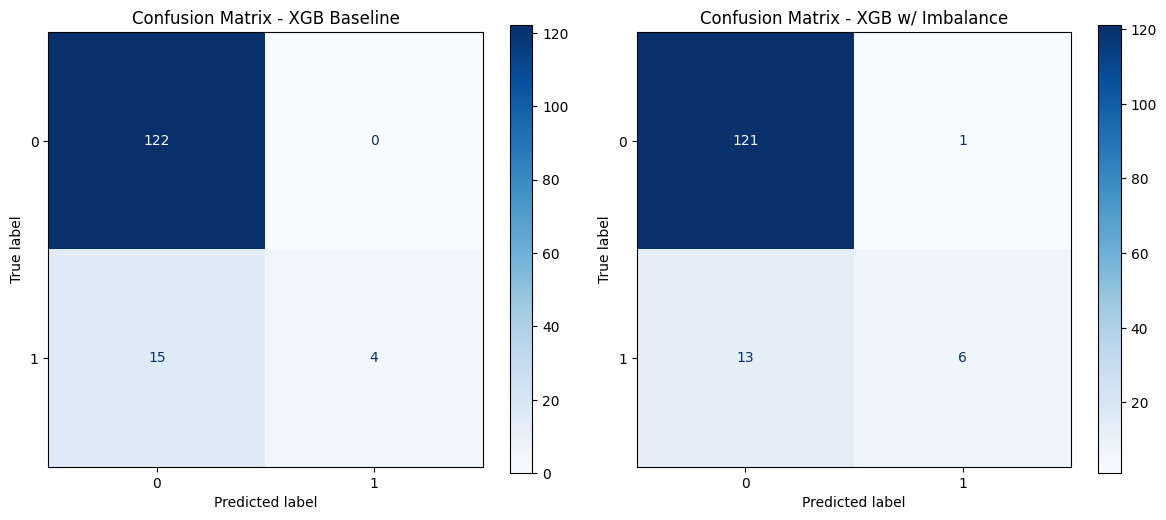

In [13]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline).tolist()
cm_imbalance = confusion_matrix(y_test, y_pred_imbalance).tolist()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_baseline, cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - XGB Baseline")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_imbalance, cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - XGB w/ Imbalance")

plt.tight_layout()
plt.show()

#### ROC Curves

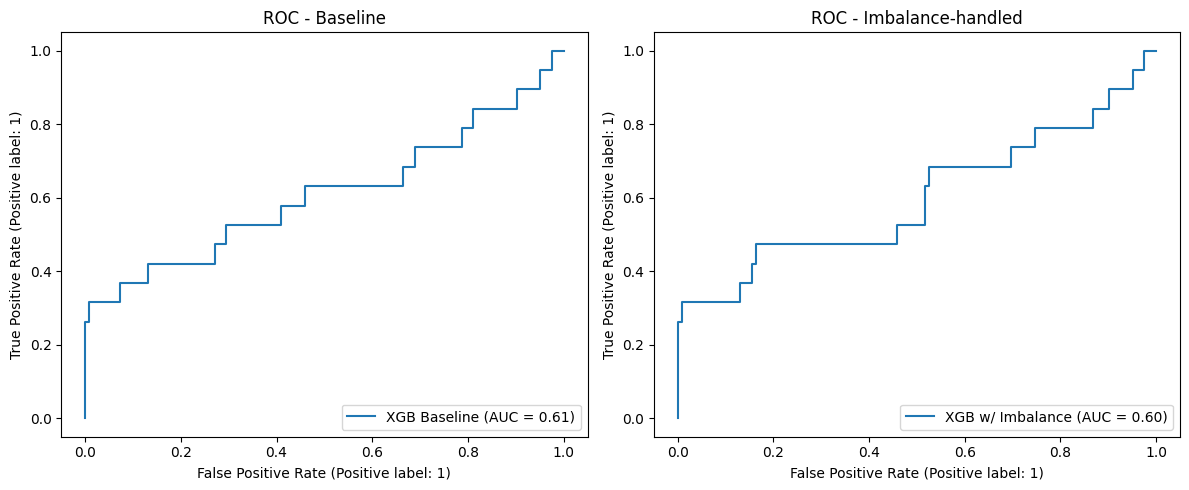

In [14]:
roc_baseline = roc_auc_score(y_test, y_proba_baseline)
roc_imbalance = roc_auc_score(y_test, y_proba_imbalance)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

RocCurveDisplay.from_predictions(y_test, y_proba_baseline, ax=axes[0], name="XGB Baseline")
axes[0].set_title("ROC - Baseline")

RocCurveDisplay.from_predictions(y_test, y_proba_imbalance, ax=axes[1], name="XGB w/ Imbalance")
axes[1].set_title("ROC - Imbalance-handled")

plt.tight_layout()
plt.show()

#### Precision-Recall Curves

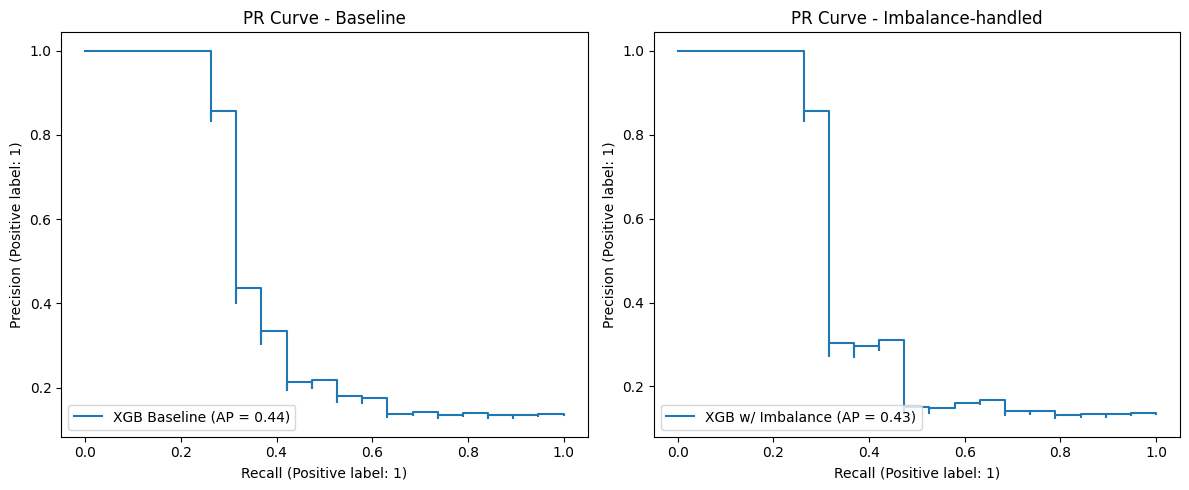


Precision-Recall (Baseline):
- PR-AUC: 0.441
- At threshold 0.5 → Precision=1.00, Recall=0.21

Precision-Recall (Imbalance-handled):
- PR-AUC: 0.432
- At threshold 0.5 → Precision=0.86, Recall=0.32



In [17]:
prec_baseline, rec_baseline, thr_baseline = precision_recall_curve(y_test, y_proba_baseline)
prec_imb, rec_imb, thr_imb = precision_recall_curve(y_test, y_proba_imbalance)

pr_auc_baseline = average_precision_score(y_test, y_proba_baseline)
pr_auc_imb = average_precision_score(y_test, y_proba_imbalance)

# Extract values at threshold 0.5
def get_pr_at_threshold(thresholds, precision, recall, target=0.5):
    idx = thresholds.searchsorted(target)
    return precision[idx], recall[idx]

prec_b, rec_b = get_pr_at_threshold(thr_baseline, prec_baseline, rec_baseline)
prec_i, rec_i = get_pr_at_threshold(thr_imb, prec_imb, rec_imb)

pr_summary = f"""
Precision-Recall (Baseline):
- PR-AUC: {pr_auc_baseline:.3f}
- At threshold 0.5 → Precision={prec_b:.2f}, Recall={rec_b:.2f}

Precision-Recall (Imbalance-handled):
- PR-AUC: {pr_auc_imb:.3f}
- At threshold 0.5 → Precision={prec_i:.2f}, Recall={rec_i:.2f}
"""

fig, axes = plt.subplots(1, 2, figsize=(12,5))

PrecisionRecallDisplay.from_predictions(y_test, y_proba_baseline, ax=axes[0], name="XGB Baseline")
axes[0].set_title("PR Curve - Baseline")

PrecisionRecallDisplay.from_predictions(y_test, y_proba_imbalance, ax=axes[1], name="XGB w/ Imbalance")
axes[1].set_title("PR Curve - Imbalance-handled")

plt.tight_layout()
plt.show()

print(pr_summary)

#### Feature Importance (summary bar plot)

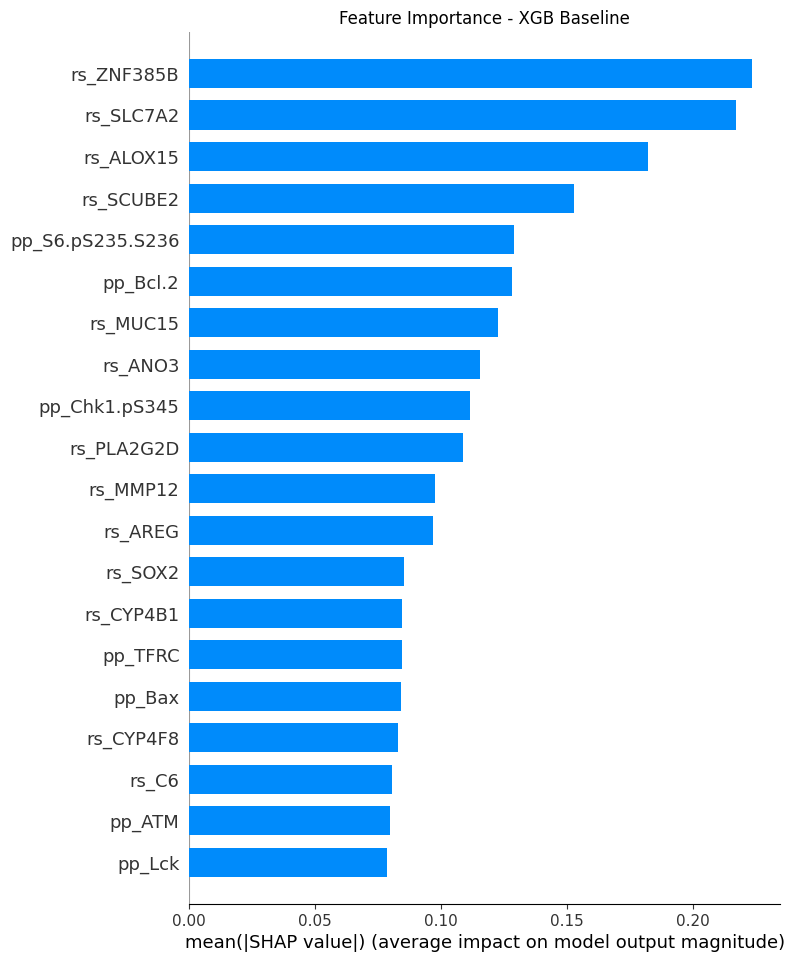

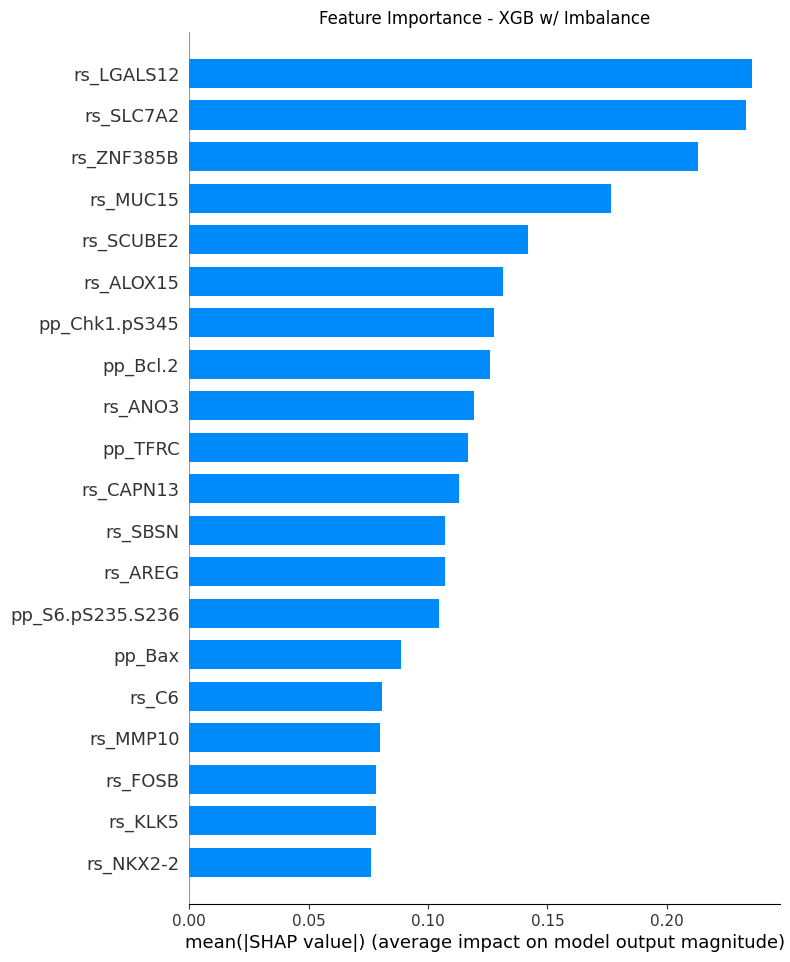

In [21]:
explainer_baseline = shap.TreeExplainer(model) 
shap_values_baseline = explainer_baseline.shap_values(X_test_baseline) 

explainer_imbalance = shap.TreeExplainer(xgb_model) 
shap_values_imbalance = explainer_imbalance.shap_values(X_test_balanced)

# Baseline model SHAP summary plot
plt.figure()
shap.summary_plot(
    shap_values_baseline, 
    X_test_baseline, 
    plot_type="bar", 
    feature_names=feature_names, 
    show=False
)
plt.title("Feature Importance - XGB Baseline")
plt.show()

# Imbalance-handled model SHAP summary plot
plt.figure()
shap.summary_plot(
    shap_values_imbalance, 
    X_test_balanced, 
    plot_type="bar", 
    feature_names=feature_names, 
    show=False
)
plt.title("Feature Importance - XGB w/ Imbalance")
plt.show()

# Compute mean absolute SHAP values
shap_mean_baseline = np.abs(shap_values_baseline).mean(axis=0)
shap_mean_imbalance = np.abs(shap_values_imbalance).mean(axis=0)

# Convert to dictionaries
shap_baseline_dict = dict(zip(feature_names, shap_mean_baseline))
shap_imbalance_dict = dict(zip(feature_names, shap_mean_imbalance))

# Print summary text
shap_summary_text = f"""
SHAP Feature Importances (mean absolute values):
- Baseline Model: {shap_baseline_dict}
- Imbalance-handled Model: {shap_imbalance_dict}
"""

#### Explanation

In [28]:
from kaggle_secrets import UserSecretsClient
from groq import Groq

user_secrets = UserSecretsClient()
client = Groq(api_key=user_secrets.get_secret("API_KEY"))

prompt = f"""
We trained two XGBoost models (baseline vs imbalance-handled).
Here are the results:

Confusion Matrices:
- Baseline: {cm_baseline}
- Imbalance: {cm_imbalance}

ROC-AUC:
- Baseline: {roc_baseline:.3f}
- Imbalance: {roc_imbalance:.3f}

Precision-Recall Summary:
{pr_summary}

{shap_summary_text}

Please provide a clear, structured explanation of these results:
1. What do the confusion matrices reveal about strengths & weaknesses of each model?
2. How do the ROC curves compare, and why is ROC-AUC important here?
3. Why is the Precision-Recall curve especially relevant for imbalanced datasets?
4. Which model seems more clinically useful for risk stratification?
5. Which features are most important according to SHAP values, and how do they differ between models? Focus on the most prominent ones, not every single feature.
6. Which of the models is the best overall, considering all of the plots and readings, based on specific clinical needs and priorities?

Important: Write the explanation in bullets or step-by-step math; avoid giving lengthy answers and keep your discussion concise and to the point.
Do not include any final boxed answers or single-number outputs.
Only provide the narrative explanation.
"""

response = client.chat.completions.create(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    messages=[{"role": "user", "content": prompt}],
    temperature=0.7,
    top_p=0.7,
    max_tokens=1500,
)

message = response.choices[0].message.content
print("Assistant:\n", message)

Assistant:
 * **Confusion Matrices Analysis**:
  * The baseline model's confusion matrix is [[122,0], [15,4]], indicating 122 true negatives, 0 false positives, 15 false negatives, and 4 true positives.
  * The imbalance-handled model's confusion matrix is [[121,1], [13,6]], indicating 121 true negatives, 1 false positive, 13 false negatives, and 6 true positives.
  * The baseline model has a higher specificity (122/122+0 = 1) but lower sensitivity (4/4+15 = 0.21) compared to the imbalance-handled model (specificity: 121/121+1 = 0.992, sensitivity: 6/6+13 = 0.32).

* **ROC-AUC Comparison**:
  * The ROC-AUC values are 0.609 for the baseline model and 0.599 for the imbalance-handled model, indicating a slightly better performance of the baseline model in distinguishing between positive and negative classes.
  * ROC-AUC measures the model's ability to distinguish between classes, with higher values indicating better performance.

* **Precision-Recall Curve Relevance**:
  * The Precision-R

## Risk Stratification

In [29]:
# Put predictions in DataFrame
risk_df = pd.DataFrame({
    "true_label": y_test,
    "proba_baseline": y_proba_baseline,
    "proba_imbalance": y_proba_imbalance
})

# Define risk groups (low, medium, high)
risk_df["risk_group_baseline"] = pd.qcut(risk_df["proba_baseline"], q=3, labels=["Low", "Medium", "High"])
risk_df["risk_group_imbalance"] = pd.qcut(risk_df["proba_imbalance"], q=3, labels=["Low", "Medium", "High"])

risk_df.head()

,true_label,proba_baseline,proba_imbalance,risk_group_baseline,risk_group_imbalance
647,0,0.035082,0.020192,High,Medium
68,0,0.004786,0.007472,Low,Low
586,0,0.012421,0.015516,Medium,Medium
564,0,0.001217,0.002885,Low,Low
312,1,0.002149,0.002209,Low,Low


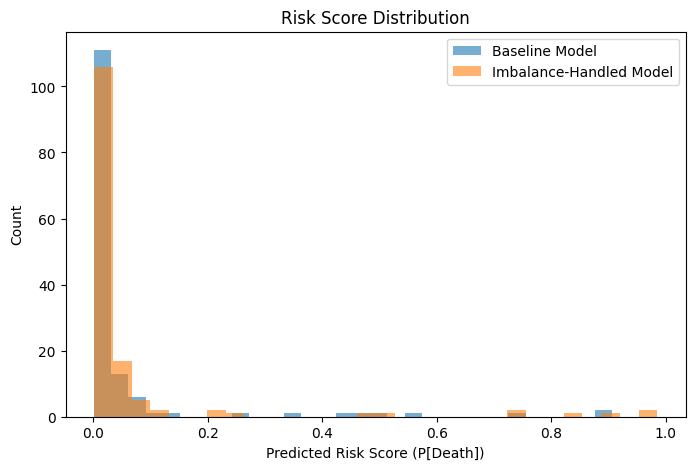

In [30]:
plt.figure(figsize=(8,5))
plt.hist(y_proba_baseline, bins=30, alpha=0.6, label="Baseline Model")
plt.hist(y_proba_imbalance, bins=30, alpha=0.6, label="Imbalance-Handled Model")
plt.xlabel("Predicted Risk Score (P[Death])")
plt.ylabel("Count")
plt.title("Risk Score Distribution")
plt.legend()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


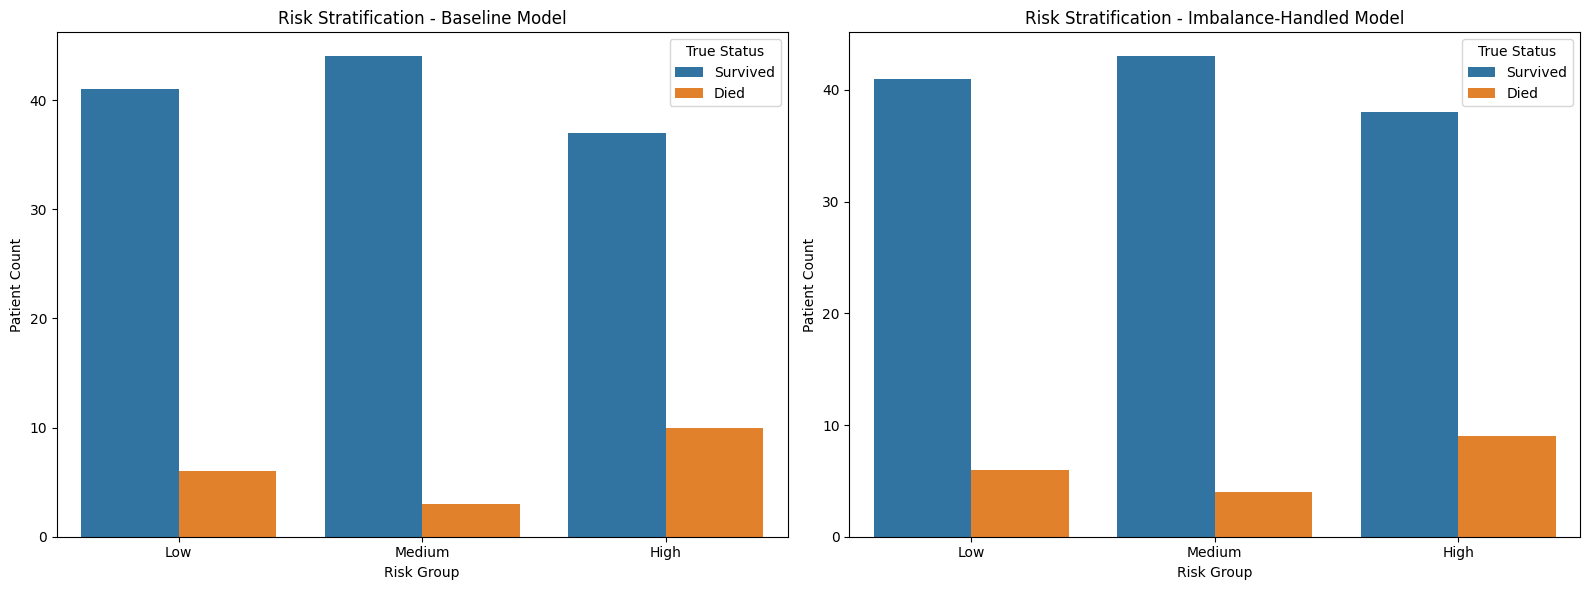

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x="risk_group_baseline", hue="true_label", data=risk_df, ax=axes[0])
axes[0].set_title("Risk Stratification - Baseline Model")
axes[0].set_xlabel("Risk Group")
axes[0].set_ylabel("Patient Count")
axes[0].legend(title="True Status", labels=["Survived", "Died"])

sns.countplot(x="risk_group_imbalance", hue="true_label", data=risk_df, ax=axes[1])
axes[1].set_title("Risk Stratification - Imbalance-Handled Model")
axes[1].set_xlabel("Risk Group")
axes[1].set_ylabel("Patient Count")
axes[1].legend(title="True Status", labels=["Survived", "Died"])

plt.tight_layout()
plt.show()

In [32]:
# Summarize risk stratification counts
baseline_counts = risk_df.groupby("risk_group_baseline")["true_label"].value_counts().unstack(fill_value=0)
imbalance_counts = risk_df.groupby("risk_group_imbalance")["true_label"].value_counts().unstack(fill_value=0)

groq_prompt = f"""
We have two XGBoost models (baseline vs imbalance-handled). Here are the risk stratification summaries:

Risk Groups (patient counts by true label):
- Baseline Model:
{baseline_counts.to_dict()}
- Imbalance-Handled Model:
{imbalance_counts.to_dict()}

The predicted risk scores were distributed as histograms (not shown here). 
Please explain:
1. How do the risk score distributions differ between models?
2. How does the stratification into low, medium, and high risk groups reflect each model's performance?
3. Which model appears more clinically useful for patient risk stratification and why?
"""

response = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[{"role": "user", "content": groq_prompt}],
    temperature=0.7,
    top_p=0.7,
    max_tokens=600,
)

message = response.choices[0].message.content
print("Assistant:\n", message)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Assistant:
 **1. How do the risk score distributions differ between models?**

Although the histograms are not shown here, we can infer some differences based on the risk stratification summaries. The key differences are:

- **Imbalance handling**: The imbalance-handled model seems to have a more even distribution of patients across the risk groups for the positive class (1). The baseline model has a higher proportion of patients in the 'High' risk group (10) compared to the imbalance-handled model (9). This suggests that the imbalance-handled model may have performed better in handling the class imbalance issue, which is a common problem in binary classification tasks.

- **Risk group assignment**: The imbalance-handled model has a slightly higher number of patients in the 'Medium' risk group for the negative class (0) compared to the baseline model (44 vs 43). This might indicate that the imbalance-handled model is more accurate in identifying patients with medium risk.

- **Consiste